# Testing Negativ Binomail and Gamma loss Data fitting and parameter estimation within PyGOM

This is an example of parameter fitting with an SIR model.

In [1]:
from pygom import Transition, TransitionType, SimulateOde, SquareLoss, PoissonLoss, NormalLoss, NegBinomLoss, GammaLoss
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import copy

from scipy.optimize import minimize

In [2]:
# Generate some data for fitting

# Standard SIR model with 2 parameters
# construct model 
states = ['S', 'I', 'R']
params = ['beta', 'gamma', 'N']
transitions = [Transition(origin='S', destination='I', equation='beta*S*I/N', 
                          transition_type=TransitionType.T),
               Transition(origin='I', destination='R', equation='gamma*I', 
                          transition_type=TransitionType.T)]
model = SimulateOde(states, params, transition=transitions)

In [3]:
# initial conditions 
N = 1e6
in_inf = 2
init_state = [N - in_inf, in_inf, 0.0]
# time 
t = np.arange (0 , 51 , 0.25)
# deterministic parameter values
param_evals = [('beta', 3.6), ('gamma', 0.2), ('N', N)]
model.parameters = param_evals
model.initial_values = (init_state, t[0])

In [4]:
# run 1 simulations
data = model.integrate(t[1:])

Data over 100 days, with observations from every day for infected and removed populations.

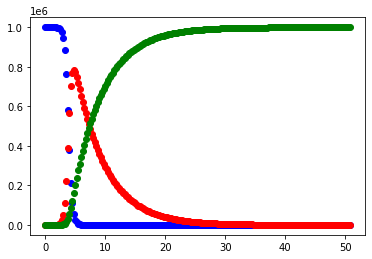

In [5]:
plt.plot(t,data[:,0], 'bo') # infected observations
plt.plot(t,data[:,1], 'ro') # infected observations
plt.plot(t,data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

# Adding random noise to produce Continuos Data

Our data needs to be have some noise so lets put it through a function for randomisation using the gamma distribution.

In [6]:
def runif_noise(x,noise_prop):
    '''
    Takes x and adds noise on the uniform distribution.
    '''
    i_len,j_len = x.shape
    ans = copy.deepcopy(x)
    for i in range(i_len):
        for j in range(j_len):
            ans[i,j]=x[i,j] + x[i,j]*np.random.uniform(low=-noise_prop,high=noise_prop,size=1)
                   
    return ans

In [7]:
data[0,:]

array([9.99998e+05, 2.00000e+00, 0.00000e+00])

In [8]:
noised_data = runif_noise(data,1/3)
#we stil want the first row from data
noised_data[0,:] = data[0,:]
(noised_data-data)/data

<ipython-input-8-74bf619963ac>:4: RuntimeWarning: invalid value encountered in true_divide
  (noised_data-data)/data


array([[ 0.00000000e+00,  0.00000000e+00,             nan],
       [-1.73465915e-01, -1.17281547e-01, -2.25860015e-02],
       [ 2.18875989e-03, -1.41630417e-01, -1.20285204e-01],
       [ 3.10984783e-01, -1.16333578e-01,  2.95271450e-01],
       [-2.69029696e-01, -1.99213726e-01, -1.90606565e-01],
       [ 1.35684509e-01,  1.78379344e-01,  1.80962883e-01],
       [-8.77803140e-02,  2.49616076e-01, -3.00454033e-02],
       [-3.04094678e-02, -3.10164909e-01,  6.59761925e-02],
       [ 4.77262892e-02, -1.92819030e-01, -1.39817160e-01],
       [ 1.70193324e-01,  1.94346231e-01,  2.65605367e-01],
       [-1.07254972e-01,  3.92049280e-02, -4.60377530e-02],
       [ 2.25368182e-01,  1.68391679e-01,  5.02529134e-02],
       [-2.73480406e-02, -2.43459230e-01, -2.72124777e-01],
       [ 3.25378306e-01,  3.11198994e-01, -3.19891929e-01],
       [-3.02732680e-02, -7.38888142e-02, -1.42714821e-01],
       [ 1.94084991e-01, -2.12622683e-01, -1.15964568e-01],
       [ 2.48373612e-01,  2.61208788e-01

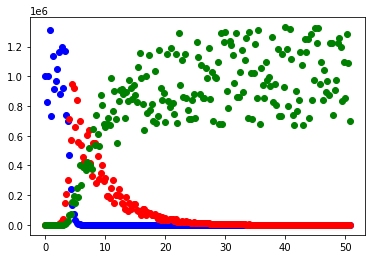

In [9]:
plt.plot(t,noised_data[:,0], 'bo') # infected observations
plt.plot(t,noised_data[:,1], 'ro') # infected observations
plt.plot(t,noised_data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

We provide a guess for $\beta$ and $\gamma$. 

This example assumes we have information about the infected and removed population, up to 50 days of the epidemic.


In [10]:
data_to_fit = noised_data[:,1:3]
data_to_fit = data_to_fit[1::,:]
data_to_fit

array([[4.13048703e+00, 1.54045618e-01],
       [9.39724796e+00, 4.63032787e-01],
       [2.26338241e+01, 1.79920071e+00],
       [4.79865867e+01, 2.75795293e+00],
       [1.65196042e+02, 9.60054641e+00],
       [4.09779333e+02, 1.85994178e+01],
       [5.28999484e+02, 4.79801484e+01],
       [1.44654291e+03, 9.06680768e+01],
       [4.99428771e+03, 3.11892868e+02],
       [1.01035804e+04, 5.48460859e+02],
       [2.61947362e+04, 1.40265491e+03],
       [3.83891964e+04, 2.23685907e+03],
       [1.44615604e+05, 4.71073992e+03],
       [2.04841144e+05, 1.28298259e+04],
       [3.04860240e+05, 2.65146845e+04],
       [7.15472624e+05, 6.60639061e+04],
       [5.70803649e+05, 7.57376290e+04],
       [9.47231329e+05, 1.54986248e+05],
       [9.23953166e+05, 1.93822492e+05],
       [6.57801248e+05, 1.50769939e+05],
       [8.43171264e+05, 2.49113150e+05],
       [5.59341253e+05, 1.85957381e+05],
       [6.96237265e+05, 4.03687883e+05],
       [5.40067509e+05, 2.66418801e+05],
       [4.574785

## Fitting Square l loss

In [11]:
param_evals

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [12]:
# Initial guess of parameters, and bounding constraints
theta = [3, 0.15,1e6]
boxBounds = [(2,5),(0.0,1.0),(1e6,1e6)]

objSIR = SquareLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [13]:
objSIR

SquareLoss([3.0, 0.15, 1000000.0], SimulateOde([ODEVariable('S', 'S', None, True), ODEVariable('I', 'I', None, True), ODEVariable('R', 'R', None, True)], [ODEVariable('beta', 'beta', None, True), ODEVariable('gamma', 'gamma', None, True), ODEVariable('N', 'N', None, True)], [], [Transition('S', 'beta*S*I/N', 'T', 'I', None, None), Transition('I', 'gamma*I', 'T', 'R', None, None)], [], []).setParameters({'beta': 3.6, 'gamma': 0.2, 'N': 1000000.0}), [999998.0, 2.0, 0.0], 0.0, [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 

In [14]:
objSIR.cost()

9032988605419.916

In [15]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 6195089026101.063
 hess_inv: array([[ 8.74144835e-12, -2.58712672e-14,  2.68445022e-06],
       [-2.58712712e-14,  2.36956010e-15, -5.05342211e-09],
       [ 2.68444976e-06, -5.05342099e-09,  8.41021723e-01]])
      jac: array([ 4.61669282e+00, -8.58643370e+01, -1.67724298e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 57
      nit: 11
     njev: 46
   status: 2
  success: False
        x: array([4.97711288e+00, 1.97932062e-01, 1.36982257e+06])


In [16]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 6195089026101.077
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.75580656e+04,  3.96915387e+06, -2.81799456e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([3.63339968e+00, 1.97932071e-01, 1.00000000e+06])


In [17]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## Fitting Normal loss

In [18]:
param_evals

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [19]:
# Initial guess of parameters, and bounding constraints
theta = [3, 0.15,1e6]
boxBounds = [(2,5),(0.0,1.0),(1e6,1e6)]

objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [20]:
objSIR

NormalLoss([3.0, 0.15, 1000000.0], SimulateOde([ODEVariable('S', 'S', None, True), ODEVariable('I', 'I', None, True), ODEVariable('R', 'R', None, True)], [ODEVariable('beta', 'beta', None, True), ODEVariable('gamma', 'gamma', None, True), ODEVariable('N', 'N', None, True)], [], [Transition('S', 'beta*S*I/N', 'T', 'I', None, None), Transition('I', 'gamma*I', 'T', 'R', None, None)], [], []).setParameters({'beta': 3.6333996818761123, 'gamma': 0.19793207076619318, 'N': 1000000.0}), [999998.0, 2.0, 0.0], 0.0, [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 2

In [21]:
objSIR.cost()

4516494303083.047

In [22]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 3097544513423.658
 hess_inv: array([[ 1.03645359e-11, -4.61156610e-14,  3.16936003e-06],
       [-4.61156587e-14,  4.75500055e-15, -8.98088545e-09],
       [ 3.16936002e-06, -8.98088607e-09,  1.00244138e+00]])
      jac: array([ 9.35430284e+04, -3.55363991e+05, -3.39879219e-01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 55
      nit: 9
     njev: 46
   status: 2
  success: False
        x: array([4.54710725e+00, 1.97932059e-01, 1.25147454e+06])


In [23]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3097544513423.661
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.87782251e+04,  1.98457720e+06, -1.40896750e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([3.63339968e+00, 1.97932071e-01, 1.00000000e+06])


In [24]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## Fitting Gamma loss

In [25]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [26]:
objSIR.sensitivity()

array([-5.77039500e+02, -6.96845671e+03,  1.73111850e-03])

In [27]:
objSIR.cost()

5058.726988342257

In [28]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4717.132458517435
 hess_inv: array([[ 3.86858865e-03, -3.00734373e-05,  3.30190074e-06],
       [-3.00734373e-05,  3.91747625e-06,  2.36516472e-08],
       [ 3.30190074e-06,  2.36516472e-08,  1.00000000e+00]])
      jac: array([ 2.13941642e-10,  3.42940432e-08, -7.68280694e-16])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 12
     njev: 27
   status: 0
  success: True
        x: array([3.59089103e+00, 1.99441546e-01, 1.00000000e+06])


In [29]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev8+g3f90a1d.d20200630-py3.8-win-amd64.egg\pygom\utilR\distn.py:108: RuntimeWarning: invalid value encountered in log
  logpdf_p3= -shape*np.log(mu/shape)


      fun: 4717.132458530734
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.00361678e-03, -6.86270665e-02, -3.60388445e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 10
     njev: 17
   status: 0
  success: True
        x: array([3.59089697e+00, 1.99441247e-01, 1.00000000e+06])


In [30]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

# Adding random noise to produce Count Data

Our data needs to a be counts:

In [31]:
int_data_to_fit = np.around(data_to_fit)
int_data_to_fit 

array([[4.000000e+00, 0.000000e+00],
       [9.000000e+00, 0.000000e+00],
       [2.300000e+01, 2.000000e+00],
       [4.800000e+01, 3.000000e+00],
       [1.650000e+02, 1.000000e+01],
       [4.100000e+02, 1.900000e+01],
       [5.290000e+02, 4.800000e+01],
       [1.447000e+03, 9.100000e+01],
       [4.994000e+03, 3.120000e+02],
       [1.010400e+04, 5.480000e+02],
       [2.619500e+04, 1.403000e+03],
       [3.838900e+04, 2.237000e+03],
       [1.446160e+05, 4.711000e+03],
       [2.048410e+05, 1.283000e+04],
       [3.048600e+05, 2.651500e+04],
       [7.154730e+05, 6.606400e+04],
       [5.708040e+05, 7.573800e+04],
       [9.472310e+05, 1.549860e+05],
       [9.239530e+05, 1.938220e+05],
       [6.578010e+05, 1.507700e+05],
       [8.431710e+05, 2.491130e+05],
       [5.593410e+05, 1.859570e+05],
       [6.962370e+05, 4.036880e+05],
       [5.400680e+05, 2.664190e+05],
       [4.574790e+05, 3.882220e+05],
       [4.259200e+05, 3.911230e+05],
       [3.969080e+05, 3.714150e+05],
 

## Poisson loss

In [32]:
# Initial guess of parameters, and bounding constraints
objSIR = PoissonLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

In [33]:
objSIR.cost()

8999599.052695096

In [34]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 3555725.9211099287
 hess_inv: array([[ 1.12854102e-07, -2.48584571e-09,  2.27949584e-06],
       [-2.48584571e-09,  9.25888041e-10,  9.47168312e-09],
       [ 2.27949584e-06,  9.47168312e-09,  1.00000832e+00]])
      jac: array([ 1.48618754e-02, -2.24162553e-02, -5.37171184e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 71
      nit: 11
     njev: 60
   status: 2
  success: False
        x: array([3.61442328e+00, 1.98453976e-01, 9.99999326e+05])


In [35]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3555725.9211287573
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.98496027e-01, -2.01665131e+02,  2.88610490e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([3.61442613e+00, 1.98453791e-01, 1.00000000e+06])


In [36]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## NegBinom loss

In [37]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev8+g3f90a1d.d20200630-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: divide by zero encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))
C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev8+g3f90a1d.d20200630-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in multiply
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


In [38]:
objSIR.sensitivity()

array([-2.86825346e+02, -3.46781844e+03,  8.60476039e-04])

In [39]:
objSIR.cost()

5038.2958154688895

In [40]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4868.230711182974
 hess_inv: array([[ 7.84349281e-03, -6.15336988e-05,  1.77314305e-06],
       [-6.15336988e-05,  7.88477962e-06,  1.39267526e-08],
       [ 1.77314305e-06,  1.39267526e-08,  1.00000000e+00]])
      jac: array([-1.03570668e-08,  1.32455900e-07,  3.71928550e-14])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 11
     njev: 16
   status: 0
  success: True
        x: array([3.59106407e+00, 1.99435913e-01, 1.00000000e+06])


In [41]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev8+g3f90a1d.d20200630-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


      fun: 4868.230711171033
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.31389989e-04, -6.80463204e-03,  2.98556969e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 26
      nit: 12
     njev: 26
   status: 0
  success: True
        x: array([3.59105802e+00, 1.99435910e-01, 1.00000000e+06])


In [42]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]